In [1]:
## Boiler plate code common to many notebooks.  See the TestFilesCommonCode.ipynb for details
from __future__ import print_function
%run TestFilesCommonCode.ipynb

SimpleITK Version: 0.9.1
Compiled: Sep 28 2015 10:07:41



In [2]:
import scipy.io
import numpy as np
from itertools import product
from sklearn.neighbors import KNeighborsClassifier

In [3]:
OUT_DIR='/raid0/homes/aghayoor/Desktop/phantom'
write_to_disk=False
verbose=False

In [4]:
def CreateFirstModality(write):
    t1=sitk.Image(128,128,sitk.sitkUInt8)
    #
    t1_arr=sitk.GetArrayFromImage(t1)
    t1_arr[8:65,43:121]=50 # tissue A or c
    t1_arr[65:80,85:121]=50 # tissue A or C
    t1_arr[8:23,43:55]=0
    t1_arr[45:55,52:67]=250 # B
    t1_arr[55:65,52:77]=250 # B
    t1_arr[65:119,8:87]=250 # tissue B
    t1_arr[100:123,65:123]=0
    t1_arr[87:100,73:123]=0
    #
    t1=sitk.GetImageFromArray(t1_arr)
    if write:
        sitk.WriteImage(t1,os.path.join(OUT_DIR,'t1.nii.gz'))
        scipy.io.savemat(os.path.join(OUT_DIR,'t1.mat'), mdict={'t1': t1_arr})
    return t1

def CreatSecondModality(write):
    t2=sitk.Image(128,128,sitk.sitkUInt8)
    #
    t2_arr=sitk.GetArrayFromImage(t2)    
    t2_arr[8:65,43:121]=200 # tissue A or c
    t2_arr[65:80,85:121]=200 # tissue A or C
    t2_arr[8:23,43:55]=0
    t2_arr[45:55,52:67]=100 # B
    t2_arr[55:65,52:77]=100 # B
    t2_arr[65:119,8:87]=100 # tissue B
    t2_arr[100:123,65:123]=0
    t2_arr[87:100,73:123]=0
    t2_arr[31:80,87:121]=150 # tissue C
    t2_arr[31:53,87:107]=200 # tissue A
    #
    t2=sitk.GetImageFromArray(t2_arr)
    if write:
        sitk.WriteImage(t2,os.path.join(OUT_DIR,'t2.nii.gz'))
        scipy.io.savemat(os.path.join(OUT_DIR,'t2.mat'), mdict={'t2': t2_arr})
    return t2

def CreateWholeOneMask(size):
    onemask = sitk.Image(size,sitk.sitkUInt8)
    onemask_arr = sitk.GetArrayFromImage(onemask)
    onemask_arr.fill(1)
    onemask = sitk.GetImageFromArray(onemask_arr)
    return onemask

def DownsampleSecondModality(t2, factor, write):
    t2_lr = sitk.Shrink(t2,[factor,factor])
    if write:
        sitk.WriteImage(t2_lr,os.path.join(OUT_DIR,'t2_lr.nii.gz'))
        t2_lr_arr=sitk.GetArrayFromImage(t2_lr)
        scipy.io.savemat(os.path.join(OUT_DIR,'t2_lr.mat'), mdict={'t2_lr': t2_lr_arr})
    return t2_lr

def CreatePurePlugsMask(t1,t2_lr,write):
    #################
    def isPurePlug(idx, t2_lr, t1):
        hspc=np.array(t2_lr.GetSpacing())
        lspc=np.array(t1.GetSpacing())
        factor=hspc/lspc
        stepSize=1/factor
        hResSize = t1.GetSize()
        # continues index
        cidx=np.array([float(i) for i in idx])
        #print('----------------------------')
        #print("index: {0}".format(cidx)) # <-----
        p = t2_lr.TransformContinuousIndexToPhysicalPoint(cidx)
        #print(p)
        #
        isInside = True
        t1_sampleValues=[]
        for iss in np.arange(cidx[0]-1.0/2+stepSize[0]/2,cidx[0]+1.0/2,stepSize[0]):
            for jss in np.arange(cidx[1]-1.0/2+stepSize[1]/2,cidx[1]+1.0/2,stepSize[1]):
                cssidx=[iss, jss]
                #
                #print("continus subsample: {0}".format(cssidx)) # <-----
                #
                p = t2_lr.TransformContinuousIndexToPhysicalPoint(cssidx)
                #
                #print("point: {0}".format(p)) # <-----
                #
                newidx = t1.TransformPhysicalPointToIndex(p)
                #
                #print("newidx: {0}".format(newidx)) # <-----
                #
                if any( newidx[i] < 0 or newidx[i] >= hResSize[i] for i in range(len(newidx))):
                    isInside = False
                    #
                    #print("is not inside") # <-----
                    #
                    break
                else:
                    t1_value = t1[newidx]
                    t1_sampleValues.append(t1_value)
            else:
                continue
            break

        ispure = False
        if isInside:
            #
            #print("sample values: ") # <-----
            #print(t1_sampleValues) # <-----
            #
            t1_arr = np.array(t1_sampleValues)
            # check to see wether the variance is zero
            # In this case, surely we have a pure plug
            var_t1 = np.var(t1_arr)
            #
            #print("var: {0}".format(var_t1)) # <-----
            #
            if var_t1 == 0: # it means that the std in at least one image is zero 
                ispure = True
            else:
                ispure = False
        #
        #print("Is pure: {0}".format(ispure)) # <-----
        #
        return ispure
    #################
    purePlugsMask = sitk.Image(t2_lr.GetSize(),sitk.sitkUInt8)
    purePlugsMask.CopyInformation(t2_lr)
    t2_lr_size = t2_lr.GetSize()
    for i in range(0,t2_lr_size[0]):
          for j in range(0,t2_lr_size[1]):
                idx=[i,j]
                if( isPurePlug(idx,t2_lr,t1) ):
                    purePlugsMask[idx] = 1
                else:
                    purePlugsMask[idx] = 0
    if write:
        sitk.WriteImage(purePlugsMask,os.path.join(OUT_DIR,'pureplugs_mask.nii.gz'))
    return purePlugsMask

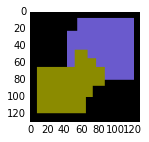

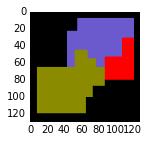

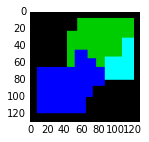

In [5]:
t1 = CreateFirstModality(write_to_disk)
t2 = CreatSecondModality(write_to_disk)
myshow(sitk.LabelToRGB(t1))
myshow(sitk.LabelToRGB(t2))
#
# segemntation baseline
seg_mask=(t2==200)*1+(t2==150)*3+(t2==100)*2
myshow(sitk.LabelToRGB(seg_mask))

In [6]:
#
#
# KNN
#
#

In [7]:
def CreateTrainingSamples(t1,t2_lr,mask,sample_num):
    trainSampleSet=[]
    trainLabels=[]
    count_b=0; count_1=0; count_2=0; count_3=0
    while( count_b < sample_num or count_1 < sample_num or count_2 < sample_num or count_3 < sample_num):
        index = np.random.randint(t1.GetSize()[0],size=(1,2))
        idx = [index[0,0].item(),index[0,1].item()]
        t1_value = t1[idx]
        p = t1.TransformIndexToPhysicalPoint(idx)
        t2_lr_idx = t2_lr.TransformPhysicalPointToIndex(p)
        if any( t2_lr_idx[i] < 0 or t2_lr_idx[i] >= t2_lr.GetSize()[i] for i in range(len(t2_lr_idx))):
            continue
        t2_lr_value = t2_lr[t2_lr_idx]
        isPure = mask[t2_lr_idx]
        if (not isPure):
            continue
        if (t2_lr_value == 0):
            if count_b >= sample_num:
                continue
            label=0
            count_b += 1
        elif (t2_lr_value == 200):
            if count_1 >= sample_num:
                continue
            label=1
            count_1 += 1
        elif (t2_lr_value == 100):
            if count_2 >= sample_num:
                continue
            label=2
            count_2 += 1
        elif (t2_lr_value == 150):
            if count_3 >= sample_num:
                continue
            label=3
            count_3 += 1
        else:
            raise ValueError('ERROR!!! invalid lable {0}'.format(t2_lr_value))
        trainSampleSet.append([t1_value,t2_lr_value])
        trainLabels.append(label)
    #print(count_b)
    #print(count_1)
    #print(count_2)
    #print(count_3)
    return trainSampleSet, trainLabels

def RunKNN(t1,t2_lr,mask,sample_num):
    n_neighbors=10
    weights='distance'
    algorithm='kd_tree'
    neigh = KNeighborsClassifier(n_neighbors=n_neighbors, weights=weights, algorithm=algorithm)
    #
    trainSampleSet, trainLabels = CreateTrainingSamples(t1,t2_lr,mask,sample_num)
    neigh.fit(trainSampleSet, trainLabels)
    #
    out_seg = sitk.Image(t1.GetSize(),sitk.sitkUInt8)
    for i in range(0,t1.GetSize()[0]):
        for j in range(0,t1.GetSize()[1]):
            idx=[i,j]
            t1_value=t1[idx]
            p = t1.TransformIndexToPhysicalPoint(idx)
            t2_lr_idx = t2_lr.TransformPhysicalPointToIndex(p)
            if any( t2_lr_idx[i] < 0 or t2_lr_idx[i] >= t2_lr.GetSize()[i] for i in range(len(t2_lr_idx))):
                out_seg[idx]=0
                continue
            t2_lr_value = t2_lr[t2_lr_idx]
            testSample = [[t1_value,t2_lr_value]]
            out_seg[idx] = neigh.predict(testSample).item()
    return out_seg

In [8]:
statsList=[]
total=128*128
for dfactor in xrange(1,11):
    print('-----')
    print(dfactor)
    t2_lr = DownsampleSecondModality(t2, dfactor, write_to_disk)
    if verbose:
        myshow(sitk.LabelToRGB(t2_lr))
    #
    purePlugsMask = CreatePurePlugsMask(t1, t2_lr, write_to_disk)
    if verbose:
        myshow(purePlugsMask)
    #
    # First run without using pureplugsmask
    onemask = CreateWholeOneMask(t2_lr.GetSize())
    out_seg1 = RunKNN(t1,t2_lr,onemask,40)
    if verbose:
        myshow(sitk.LabelToRGB(out_seg1))
    diff1=abs(seg_mask-out_seg1)>0
    if verbose:
        myshow(diff1)
    stats1=sitk.StatisticsImageFilter()
    stats1.Execute(diff1)
    error_old=stats1.GetSum()
    print(error_old)
    # Now run using pureplugsmask
    out_seg2 = RunKNN(t1,t2_lr,purePlugsMask,40)
    if verbose:
        myshow(sitk.LabelToRGB(out_seg2))
    diff2=abs(seg_mask-out_seg2)>0
    if verbose:
        myshow(diff2)
    stats2=sitk.StatisticsImageFilter()
    stats2.Execute(diff2)
    error_new=stats2.GetSum()
    print(error_new)
    statsList.append([dfactor,(error_old/total)*100,(error_new/total)*100])

-----
1
0.0
0.0
-----
2
299.0
284.0
-----
3
367.0
292.0
-----
4
361.0
361.0
-----
5
754.0
754.0
-----
6
610.0
558.0
-----
7
578.0
496.0
-----
8
591.0
575.0
-----
9
990.0
858.0
-----
10
1659.0
1176.0


In [9]:
def writeOutputFile(filename,dataList):
    import csv
    with open(filename, 'w') as lf:
        #headerdata = [['#factor','old_method','new_method']]
        wr = csv.writer(lf, delimiter=',')
        #wr.writerows(headerdata)
        wr.writerows(dataList)
        
csv_fn = os.path.join(OUT_DIR,'stats.csv')
writeOutputFile(csv_fn,statsList)

In [10]:
# plot the output diagram
import pandas as pd
from ggplot import *

In [11]:
DataFrame = pd.read_csv(csv_fn)

In [12]:
print(DataFrame)

    1        0.0     0.0.1
0   2   1.824951  1.733398
1   3   2.239990  1.782227
2   4   2.203369  2.203369
3   5   4.602051  4.602051
4   6   3.723145  3.405762
5   7   3.527832  3.027344
6   8   3.607178  3.509521
7   9   6.042480  5.236816
8  10  10.125732  7.177734


In [13]:
# p1 = ggplot(aes('factor', 'old_method'), data=DataFrame ) \
# + geom_point(alpha=1,size=60) \
# + xlim(-1, 10) \
# + scale_x_continuous(breaks=(1,2,3,4,5,6,7,8,9,10)) \
# + ylim(0, 50) \
# + geom_line(size=1.5) \
# + labs(x='Downsampling factor', y='Segmentation Error (%)', title='Error') \
# + theme(axis_title=element_text(size=25),axis_text=element_text(size=18),title=element_text(size=25))
# print(p1)

In [14]:
sitk.WriteImage(diff2,os.path.join(OUT_DIR,'diff2.nii.gz'))

In [15]:
def CreateFirstModality(write):
    t1=sitk.Image(128,128,sitk.sitkUInt8)
    #
    t1_arr=sitk.GetArrayFromImage(t1)
    t1_arr[8:65,41:119]=50 # tissue A or c
    t1_arr[65:80,87:119]=50 # tissue A or C
    t1_arr[8:23,41:51]=0
    t1_arr[45:55,52:67]=250 # B
    t1_arr[55:65,52:77]=250 # B
    t1_arr[65:119,8:87]=250 # tissue B
    t1_arr[100:123,65:123]=0
    t1_arr[87:100,73:123]=0
    #
    t1=sitk.GetImageFromArray(t1_arr)
    if write:
        sitk.WriteImage(t1,os.path.join(OUT_DIR,'t1.nii.gz'))
        scipy.io.savemat(os.path.join(OUT_DIR,'t1.mat'), mdict={'t1': t1_arr})
    return t1

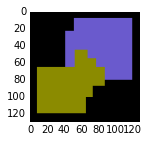

In [16]:
t1 = CreateFirstModality(False)
myshow(sitk.LabelToRGB(t1))

In [17]:
def CreatSecondModality(write):
    t2=sitk.Image(128,128,sitk.sitkUInt8)
    #
    t2_arr=sitk.GetArrayFromImage(t2)    
    t2_arr[8:65,41:119]=200 # tissue A or c
    t2_arr[65:80,87:119]=200 # tissue A or C
    t2_arr[8:23,41:51]=0
    t2_arr[45:55,52:67]=100 # B
    t2_arr[55:65,52:77]=100 # B
    t2_arr[65:119,8:87]=100 # tissue B
    t2_arr[100:123,65:123]=0
    t2_arr[87:100,73:123]=0
    t2_arr[31:80,87:119]=150 # tissue C
    t2_arr[31:53,87:107]=200 # tissue A
    #
    t2=sitk.GetImageFromArray(t2_arr)
    if write:
        sitk.WriteImage(t2,os.path.join(OUT_DIR,'t2.nii.gz'))
        scipy.io.savemat(os.path.join(OUT_DIR,'t2.mat'), mdict={'t2': t2_arr})
    return t2

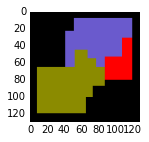

In [18]:
t2 = CreatSecondModality(False)
myshow(sitk.LabelToRGB(t2))